In [86]:
import pandas as pd

# format data frame in preparation for analysis
def clean_data(data_frame):
    print(data_frame.columns)

    # remove rows from data for when participants incorrectly identified the smaller of the pair of stimuli
    data_frame['FCWrong'].fillna(0,inplace=True)
#     clean = data_frame.loc[data_frame['FCWrong'] < 1]
    
    # arrange data so that participant performance for each trial in vis and tactile are aligned for within subjects analysis
    clean = data_frame.sort_values(by=['condition','participant_id','label','trial_order'])
    
    return clean

# transform raw values for analysis
def transform_data(data_frame):
    
    # create a new column for absolute error following Cleveland and McGill 1986
    # (doi: https://doi.org/10.1016/S0020-7373(86)80019-0)
    # |judged percentage - true percentage|
    data_frame['abs_error'] = abs(data_frame['RespondedPercent'] - data_frame['truePercent'])
    print(data_frame)
    return data_frame
    
# Clean data
f = 'perception_tasks.csv'
tab = 'tabular_data.csv'
data = pd.read_csv(f, header=0)
tab_data = pd.read_csv(tab, header=0)
d = clean_data(data)
d = transform_data(d)


Index(['participant_id', 'FCWrong', 'type', 'condition', 'RespondedPercent',
       'truePercent', 'abs_error', 'condition_order', 'label', 'trial_order'],
      dtype='object')
    participant_id  FCWrong      type condition  RespondedPercent  \
581             P1      0.0     areas   Tactile                20   
576             P1      0.0     areas   Tactile                30   
577             P1      0.0     areas   Tactile                50   
578             P1      0.0     areas   Tactile                50   
579             P1      0.0     areas   Tactile                50   
..             ...      ...       ...       ...               ...   
266             P9      0.0  textures    Visual                38   
267             P9      0.0  textures    Visual                50   
268             P9      0.0  textures    Visual                55   
269             P9      0.0  textures    Visual                77   
264             P9      0.0  textures    Visual                

In [87]:
from scipy import stats
from statsmodels.stats import descriptivestats as desc_st

# H1: Participants will characterize the difference between the pairs of stimuli most accurately for the visual encoding, 
# followed by tabular encodings, and lastly, the tactile encodings.

# align participant data so that their performance in the tactile and visual conditions are directly comparable
def align_data(data_frame):
    
    # align participant trial data for both tactile and visual conditions
    data_frame['p_trial_id'] = ['-'.join(i) for i in zip(data_frame['participant_id'].apply(str),
                                                        data_frame['trial_order'].apply(str))]
    data_frame = data_frame.pivot(index='p_trial_id', columns='condition', values='FCWrong')
    print(data_frame)
    return data_frame

# descriptive statistics for accuracy
def acc(data_frame):
    desc = data_frame[['Tactile','Visual']].describe()
    # print(desc)
    count = data_frame[['Tactile','Visual']].value_counts()
    # print(count)
    return data_frame
    
# run the matched pairs signed test
def test_h1(data_frame):
    data_frame['matched'] = data_frame['Visual'] - data_frame['Tactile']
    result = desc_st.sign_test(data_frame['matched'])
    print(result)
    return data_frame

m_data = align_data(d) # align the data for analysis
desc_data = acc(m_data) # print out descriptive stats
test_data = test_h1(m_data) # run the matched signs test; this is an oversimplification (aligned rank transform might
                            # be more appropriate, but we don't have time right now)

condition   Tactile  Visual
p_trial_id                 
P1-1            0.0     0.0
P1-10           0.0     0.0
P1-11           0.0     0.0
P1-12           0.0     0.0
P1-13           1.0     0.0
...             ...     ...
P9-5            0.0     0.0
P9-6            0.0     0.0
P9-7            0.0     0.0
P9-8            0.0     0.0
P9-9            0.0     0.0

[432 rows x 2 columns]
(-3.5, 0.09228515625)


In [88]:
# this function counts the number of ones in the column
def count_ones_in_each_column(df):
    ones_count = {}
    for col in df.columns:
        ones_count[col] = (df[col] == 1.0).sum()
    return ones_count


result = count_ones_in_each_column(test_data)
print(result)


{'Tactile': 10, 'Visual': 3, 'matched': 3}


In [89]:
# H2: Participants will perceive proportion differences most accurately for the tabular encodings, followed by visual 
# encodings, and lastly, tactile encodings. (what percentage is the smaller value of the larger?) 

def align_data(data_frame):
    
    # align participant trial data for both tactile and visual conditions
    data_frame['p_label_id'] = ['-'.join(i) for i in zip(data_frame['participant_id'].apply(str),
                                                        data_frame['label'].apply(str))]
    # data_frame = data_frame.pivot(index='p_label_id', columns='condition', values=['abs_error', 'participant_id'])
    print(data_frame)
    return data_frame

h2_data = align_data(d)

    participant_id  FCWrong      type condition  RespondedPercent  \
581             P1      0.0     areas   Tactile                20   
576             P1      0.0     areas   Tactile                30   
577             P1      0.0     areas   Tactile                50   
578             P1      0.0     areas   Tactile                50   
579             P1      0.0     areas   Tactile                50   
..             ...      ...       ...       ...               ...   
266             P9      0.0  textures    Visual                38   
267             P9      0.0  textures    Visual                50   
268             P9      0.0  textures    Visual                55   
269             P9      0.0  textures    Visual                77   
264             P9      0.0  textures    Visual                80   

     truePercent  abs_error  condition_order       label  trial_order  \
581           25          5                1     areas_0           36   
576           35         

In [90]:
from statsmodels.stats.anova import AnovaRM
## for H2, we perform RMANOVA to compare the MAE of visual and tactile conditions. Tabular condition will have descriptive analysis.
## we then run paired f-test, and use bonferroni correction to get corrected p values between pairs. 

import pingouin as pg

def perform_rmanova(df):
    rmanova = pg.rm_anova(
        data=df,
        dv='abs_error',  # dependent variable
        within='condition',  # use condition as within subject variable
        subject='participant_id',  # account for unique participant
        detailed=False,  # return only the summary, not detailed results
    )

    return rmanova

def perform_pairwise_ftest(df):
    pairwise_ftest = pg.pairwise_tests(
        data=df,
        dv='abs_error',
        within='condition',
        subject='participant_id',
        within_first=['Visual', 'Tactile'],
        padjust='bonferroni',  # No adjustment for multiple comparisons
    )

    return pairwise_ftest


# perform rmanova on comparing abs_err between visual and tactile
print("--------Compare MAE between visual and tactile conditions---------")
result = perform_rmanova(h2_data)
print(result)

# perform pairwise F-test between visual and tactile conditions
print("--------Pairwise F-test between visual and tactile conditions---------")
pairwise_result = perform_pairwise_ftest(h2_data)
print(pairwise_result)

print("--------descriptive analysis for all 3 conditions---------")
print("Tabular Condition MAE: ", tab_data['abs_diff'].mean())
print("Visual Condition MAE: ", h2_data.loc[h2_data["condition"] == "Visual", "abs_error"].mean())
print("Tactile Condition MAE: ", h2_data.loc[h2_data["condition"] == "Tactile", "abs_error"].mean())


--------Compare MAE between visual and tactile conditions---------
      Source  ddof1  ddof2         F     p-unc       ng2  eps
0  condition      1     11  8.477959  0.014146  0.174621  1.0
--------Pairwise F-test between visual and tactile conditions---------
    Contrast        A       B  Paired  Parametric         T   dof alternative  \
0  condition  Tactile  Visual    True        True  2.911693  11.0   two-sided   

      p-unc   BF10    hedges  
0  0.014146  4.472  0.850388  
--------descriptive analysis for all 3 conditions---------
Tabular Condition MAE:  6.069444444444445
Visual Condition MAE:  10.333333333333334
Tactile Condition MAE:  12.835648148148149


In [91]:
# H3: The order of accuracy for visual encodings will replicate the order found in Cleveland and McGill experiments 
#(position on an aligned scale, position on an unaligned scale, length, area, curvature, shading), but will differ 
# for comparable tactile encodings. The accuracy for the table encoding will be better than all visual and tactile encodings. 

# We will compare MAE of each encoding channels within condition using RMANOVA. Tabular condition will have descriptive analysis, the same as previous . 
# first we separate visual and tactile condition to 2 dfs

# Separate the dataframe into two based on condition
tactile_df = h2_data[h2_data['condition'] == 'Tactile']
visual_df = h2_data[h2_data['condition'] == 'Visual']

def perform_rmanova_condition(df):
    rmanova = pg.rm_anova(
        data=df,
        dv='abs_error',  # dependent variable
        within='type',  # use encoding channel type as within subject variable
        subject='participant_id',  # account for unique participant
        detailed=False,  # return only the summary, not detailed results
    )

    return rmanova

def perform_pairwise_ftest_type(df):
    pairwise_ftest = pg.pairwise_tests(
        data=df,
        dv='abs_error',
        within='type',
        subject='participant_id',
        padjust='none',  # No adjustment for multiple comparisons
    )

    return pairwise_ftest

print('-------Tactile condition RMANOVA Results------')
print(perform_rmanova_condition(tactile_df))
print('-------Visual condition RMANOVA Results------')
print(perform_rmanova_condition(visual_df))

# Perform pairwise F-test for the "type" within the tactile condition
print("--------Pairwise F-test for the 'type' within the tactile condition---------")
pairwise_result_tactile = perform_pairwise_ftest_type(tactile_df)
print(pairwise_result_tactile)

# Perform pairwise F-test for the "type" within the visual condition
print("--------Pairwise F-test for the 'type' within the visual condition---------")
pairwise_result_visual = perform_pairwise_ftest_type(visual_df)
print(pairwise_result_visual)



-------Tactile condition RMANOVA Results------
  Source  ddof1  ddof2         F     p-unc       ng2       eps
0   type      5     55  4.574793  0.001467  0.212596  0.733687
-------Visual condition RMANOVA Results------
  Source  ddof1  ddof2          F         p-unc  p-GG-corr       ng2  \
0   type      5     55  13.514495  1.330370e-08   0.000025  0.489069   

        eps  sphericity   W-spher  p-spher  
0  0.512737       False  0.064577  0.04065  
--------Pairwise F-test for the 'type' within the tactile condition---------
   Contrast                   A                   B  Paired  Parametric  \
0      type               areas          curvatures    True        True   
1      type               areas               lines    True        True   
2      type               areas    position_aligned    True        True   
3      type               areas  position_unaligned    True        True   
4      type               areas            textures    True        True   
5      type        

In [92]:
import statsmodels.stats.multitest as smm

alpha = 0.05
p_values = pairwise_result_tactile['p-unc'].values
reject, corrected_p_values, _, new_alpha = smm.multipletests(p_values, alpha=alpha, method='bonferroni')

pairwise_result_tactile['p-corrected'] = corrected_p_values
print(new_alpha)
print(reject)
print(pairwise_result_tactile)

p_values = pairwise_result_visual['p-unc'].values
reject, corrected_p_values, _, new_alpha = smm.multipletests(p_values, alpha=alpha, method='bonferroni')

pairwise_result_visual['p-corrected'] = corrected_p_values
print(new_alpha)
print(reject)
print(pairwise_result_visual)


0.0033333333333333335
[False False False False False False False False False False False False
 False False False]
   Contrast                   A                   B  Paired  Parametric  \
0      type               areas          curvatures    True        True   
1      type               areas               lines    True        True   
2      type               areas    position_aligned    True        True   
3      type               areas  position_unaligned    True        True   
4      type               areas            textures    True        True   
5      type          curvatures               lines    True        True   
6      type          curvatures    position_aligned    True        True   
7      type          curvatures  position_unaligned    True        True   
8      type          curvatures            textures    True        True   
9      type               lines    position_aligned    True        True   
10     type               lines  position_unaligned    True 

In [93]:
# to better explore H3, we also perform descriptive analysis to inspect MAE of each encoding channel type

# here is a function that displays mean abs_err for each encoding channel type
def mean_abs_error_by_type(df):
    mean_abs_error = df.groupby('type')['abs_error'].mean()
    print(mean_abs_error)

print('-------Tactile condition Encoding Channels Results------')
mean_abs_error_by_type(tactile_df)
print('-------Visual condition Encoding Channels Results------')
mean_abs_error_by_type(visual_df)


-------Tactile condition Encoding Channels Results------
type
areas                 11.361111
curvatures            18.138889
lines                  9.569444
position_aligned      12.708333
position_unaligned    10.458333
textures              14.777778
Name: abs_error, dtype: float64
-------Visual condition Encoding Channels Results------
type
areas                 10.736111
curvatures            16.597222
lines                  7.041667
position_aligned       6.125000
position_unaligned     6.708333
textures              14.791667
Name: abs_error, dtype: float64


In [94]:
# H4: The tabular condition will result in the highest cognitive load, 
# followed by the tactile condition, and lastly, the visual condition. 

# read in data for likert questions
l_df = pd.read_csv('likert_results.csv')

# Rename the columns
new_column_names = {
    '1=leastaccuracy 7=highestaccuracy - Tactile': 'self_performance_tactile',
    '1=extremelyeasy 10=extremelydemanding - Tactile': 'cog1_tactile',
    '1=extremelyrelaxed 10=extremelystressed - Tactile': 'cog2_tactile',
    '1=leastaccuracy 7=highestaccuracy - Visual': 'self_performance_visual',
    '1=extremelyeasy 10=extremelydemanding - Visual': 'cog1_visual',
    '1=extremelyrelaxed 10=extremelystressed - Visual': 'cog2_visual',
    '1=leastaccuracy 7=highestaccuracy - Tabular': 'self_performance_tabular',
    '1=extremelyeasy 10=extremelydemanding - Tabular': 'cog1_tabular',
    '1=extremelyrelaxed 10=extremelystressed - Tabular': 'cog2_tabular'
}

l_df.rename(columns=new_column_names, inplace=True)
l_df

,participant_id,self_performance_tactile,cog1_tactile,cog2_tactile,self_performance_visual,cog1_visual,cog2_visual,self_performance_tabular,cog1_tabular,cog2_tabular
0,P1,4,2,3,6,2,1,5,6,3
1,P2,4,5,2,2,9,2,5,5,6
2,P3,2,4,3,4,5,5,5,7,7
3,P4,3,8,5,5,6,3,6,4,2
4,P5,4,6,2,4,5,3,2,7,7
5,P6,3,6,4,4,6,5,4,6,6
6,P7,4,10,9,5,8,7,5,7,6
7,P8,3,6,3,6,4,4,5,6,7
8,P9,4,5,5,5,5,5,5,3,2
9,P10,3,8,4,4,5,3,2,3,5


In [95]:
import scipy.stats

# For H3-5, we first check the skewness of the responses

def check_skewness(df, columns):
    for col in columns:
        skewness = scipy.stats.skew(df[col])
        print(f"Skewness of {col}: {skewness}")

columns_to_check = [
    'self_performance_tactile', 'cog1_tactile', 'cog2_tactile',
    'self_performance_visual', 'cog1_visual', 'cog2_visual',
    'self_performance_tabular', 'cog1_tabular', 'cog2_tabular'
]

# Use the function to check skewness
check_skewness(l_df, columns_to_check)

Skewness of self_performance_tactile: -0.4156921938165305
Skewness of cog1_tactile: -0.12469593727770993
Skewness of cog2_tactile: 1.0775269545164956
Skewness of self_performance_visual: -0.6651477158057466
Skewness of cog1_visual: 0.09172629494271808
Skewness of cog2_visual: 0.2855013409527254
Skewness of self_performance_tabular: -1.1389043647113861
Skewness of cog1_tabular: -0.26047265350325466
Skewness of cog2_tabular: -0.510899626526005


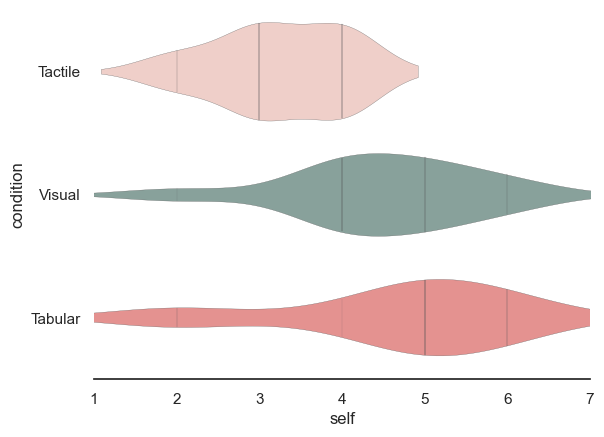

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns

def plot_violin(data):
    # Melt the dataframe to long format and calculate cog_mean
    melted_df = data.melt(id_vars=['participant_id'], value_vars=['self_performance_tactile', 'self_performance_visual', 'self_performance_tabular'], var_name='condition', value_name='self_performance')
    cog_mean = melted_df.groupby('condition')['self_performance'].mean().values
    
    # Plot the violin using Seaborn
    sns.set(style='white')
    ax = sns.violinplot(x='self_performance', y='condition', data=melted_df, inner='sticks', palette=colors, linewidth=0.2)
    ax.set_yticklabels(['Tactile', 'Visual', 'Tabular'])
    
    # Set the x-axis label
    plt.xlabel('self')
    plt.xlim(1,7)
    
    
    # Show the plot
    plt.show()


# Example usage
plot_violin(l_df)



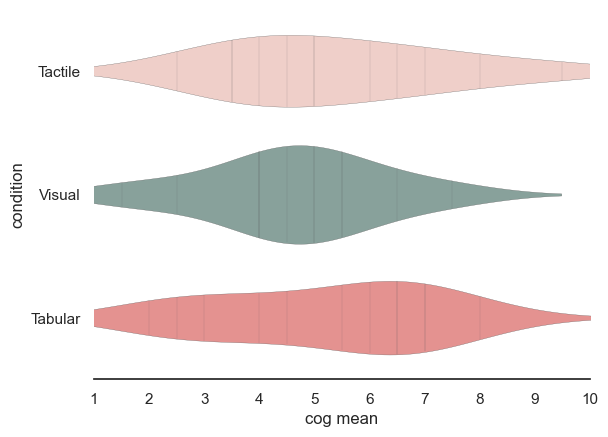

In [154]:
import pandas as pd


# calculate the mean of cog1 + cog2 for all three conditions
l_df['cog_mean_tactile'] = (l_df['cog1_tactile'] + l_df['cog2_tactile']) / 2
l_df['cog_mean_visual'] = (l_df['cog1_visual'] + l_df['cog2_visual']) / 2
l_df['cog_mean_tabular'] = (l_df['cog1_tabular'] + l_df['cog2_tabular']) / 2

colors = ['#f5cac3', '#84a59d', '#f28482']

def plot_cog_mean_violin(data):
    # Melt the dataframe to long format and calculate cog_mean
    melted_df = data.melt(id_vars=['participant_id'], value_vars=['cog_mean_tactile', 'cog_mean_visual', 'cog_mean_tabular'], var_name='condition', value_name='cog_mean')
    cog_mean = melted_df.groupby('condition')['cog_mean'].mean().values
    
    # Plot the violin using Seaborn
    sns.set(style='white')
    ax = sns.violinplot(x='cog_mean', y='condition', data=melted_df, inner='stick', palette=colors, linewidth=0.2)
    ax.set_yticklabels(['Tactile', 'Visual', 'Tabular'])
    
    # # Add the mean as a vertical line
    # for i, mean in enumerate(cog_mean):
    #     plt.axvline(mean, color=colors[i], linestyle='--', linewidth=2)
    
    # Set the x-axis label
    plt.xlabel('cog mean')
    plt.xlim(1,10)
    
    # Remove the borders
    sns.despine(left=True)
    
    # Show the plot
    plt.show()


plot_cog_mean_violin(l_df)
